
##Mounting Google Drive


In [1]:
from google.colab import drive
drive.mount('../content/drive/', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ../content/drive/


##Importing neccessary modules


In [2]:
from __future__ import division
import six
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import regularizers
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras import optimizers
from keras.datasets import cifar10

import numpy as np
import time
import matplotlib.pyplot as plt
% matplotlib inline
np.random.seed(2017) 
import cv2

Using TensorFlow backend.


##Loading data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  x_train.shape
num_test, _, _, _ =  x_test.shape
num_classes = len(np.unique(y_train))

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# len_train, len_test = len(x_train), len(x_test)
# y_train = y_train.astype('int64').reshape(len_train)
# y_test = y_test.astype('int64').reshape(len_test)

# train_mean = np.mean(x_train, axis=(0,1,2))
# train_std = np.std(x_train, axis=(0,1,2))

# normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
# pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

# x_train = normalize(pad4(x_train))
# x_test = normalize(x_test)

##Visualizing the sample data

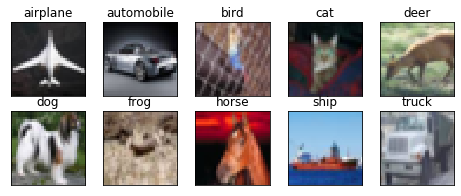

In [5]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

##Preprocessing & Augmentation of data


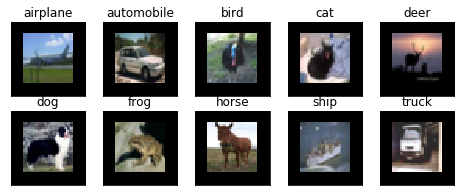

In [7]:
#Padding the input image with 4 pixels on all sides
def padd(im):
  img= cv2.copyMakeBorder(im,8,8,8,8,cv2.BORDER_CONSTANT)
  return img


class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    img = padd(im)
    ax.set_title(class_names[i])
    plt.imshow(img)
plt.show()

##Random Cropping

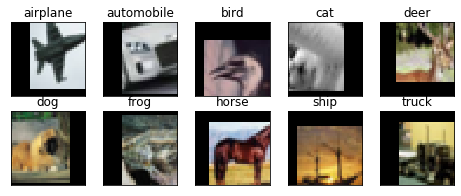

In [8]:
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    img = padd(im)
    img = random_crop(img, random_crop_size = (32,32))
    ax.set_title(class_names[i])
    plt.imshow(img)
plt.show()

In [0]:
def padcrop():
    imgp = padd(img)
    imgpc = random_crop(imgp, random_crop_size = (32,32))


    return imgpc

In [0]:
# import numpy as np


# def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
#     def eraser(input_img):
#         img_h, img_w, img_c = input_img.shape
#         p_1 = np.random.rand()

#         if p_1 > p:
#             return input_img

#         while True:
#             s = np.random.uniform(s_l, s_h) * img_h * img_w
#             r = np.random.uniform(r_1, r_2)
#             w = int(np.sqrt(s / r))
#             h = int(np.sqrt(s * r))
#             left = np.random.randint(0, img_w)
#             top = np.random.randint(0, img_h)

#             if left + w <= img_w and top + h <= img_h:
#                 break

#         if pixel_level:
#             c = np.random.uniform(v_l, v_h, (h, w, img_c))
#         else:
#             c = np.random.uniform(v_l, v_h)

#         input_img[top:top + h, left:left + w, :] = c

#         return input_img

#     return eraser

In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
# def get_random_eraser(p=0.25, s_l=0.01, s_h=0.2, r_1=0.15, r_2=0.5/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img= padd(input_img)
        # input_img[top:top + h, left:left + w, :] = c
        input_img= random_crop(input_img, random_crop_size =(32,32))
        

        return input_img

    return eraser




    #   imgp = padd(img)
    # imgpc = random_crop(imgp, random_crop_size = (32,32))

**Use Normalization values of: (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)**

In [12]:
x_train = x_train.astype('float32') / 255
x_test= x_test.astype('float32') / 255
train_mean = np.mean(x_train, axis=(0,1,2))
train_mean

array([0.4914009 , 0.48215896, 0.4465308 ], dtype=float32)

In [13]:
train_std = np.std(x_train, axis=(0,1,2))
train_std

array([0.24703279, 0.24348423, 0.26158753], dtype=float32)

In [0]:

normalize = lambda x: ((x - train_mean) / train_std).astype('float32')
X_train = normalize(x_train)
X_test  = normalize(x_test)

In [0]:
pixel_level = False
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization= False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=0.5,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    preprocessing_function=get_random_eraser(p=0.25, s_l=0.01, s_h=0.2, r_1=0.15, r_2=0.5/0.3, v_l=0, v_h=255, pixel_level=False))

datagen.fit(X_train)

In [0]:
# print(x_train.shape, x_train.mean(), x_train.std())
# x_train = x_train.astype('float32') / 255
# print(x_train.shape, x_train.mean(), x_train.std())

In [0]:
# print(x_test.shape, x_train.mean(), x_train.std())
# x_test = x_test.astype('float32') / 255
# print(x_test.shape, x_train.mean(), x_train.std())

In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# X_train = (x_train - x_train.mean())/x_train.std()
# X_test = (x_test- x_train.mean())/x_train.std()

##ResNet model

In [0]:

def _bn_relu(x, bn_name=None, relu_name=None):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS, name=bn_name)(x)
    return Activation("relu", name=relu_name)(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu residual unit activation function.
       This is the original ResNet v1 scheme in https://arxiv.org/abs/1512.03385
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                   strides=strides, padding=padding,
                   dilation_rate=dilation_rate,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer,
                   name=conv_name)(x)
        return _bn_relu(x, bn_name=bn_name, relu_name=relu_name)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv residual unit with full pre-activation
    function. This is the ResNet v2 scheme proposed in
    http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    dilation_rate = conv_params.setdefault("dilation_rate", (1, 1))
    conv_name = conv_params.setdefault("conv_name", None)
    bn_name = conv_params.setdefault("bn_name", None)
    relu_name = conv_params.setdefault("relu_name", None)
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(x):
        activation = _bn_relu(x, bn_name=bn_name, relu_name=relu_name)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      dilation_rate=dilation_rate,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer,
                      name=conv_name)(activation)

    return f


def _shortcut(input_feature, residual, conv_name_base=None, bn_name_base=None):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input_feature)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input_feature
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        print('reshaping via a convolution...')
        if conv_name_base is not None:
            conv_name_base = conv_name_base + '1'
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001),
                          name=conv_name_base)(input_feature)
        if bn_name_base is not None:
            bn_name_base = bn_name_base + '1'
        shortcut = BatchNormalization(axis=CHANNEL_AXIS,
                                      name=bn_name_base)(shortcut)

    return add([shortcut, residual])


def _residual_block(block_function, filters, blocks, stage,
                    transition_strides=None, transition_dilation_rates=None,
                    dilation_rates=None, is_first_layer=False, dropout=None,
                    residual_unit=_bn_relu_conv):
    """Builds a residual block with repeating bottleneck blocks.
       stage: integer, current stage label, used for generating layer names
       blocks: number of blocks 'a','b'..., current block label, used for generating
            layer names
       transition_strides: a list of tuples for the strides of each transition
       transition_dilation_rates: a list of tuples for the dilation rate of each
            transition
    """
    if transition_dilation_rates is None:
        transition_dilation_rates = [(1, 1)] * blocks
    if transition_strides is None:
        transition_strides = [(1, 1)] * blocks
    if dilation_rates is None:
        dilation_rates = [1] * blocks

    def f(x):
        for i in range(blocks):
            is_first_block = is_first_layer and i == 0
            x = block_function(filters=filters, stage=stage, block=i,
                               transition_strides=transition_strides[i],
                               dilation_rate=dilation_rates[i],
                               is_first_block_of_first_layer=is_first_block,
                               dropout=dropout,
                               residual_unit=residual_unit)(x)
        return x

    return f


def _block_name_base(stage, block):
    """Get the convolution name base and batch normalization name base defined by
    stage and block.
    If there are less than 26 blocks they will be labeled 'a', 'b', 'c' to match the
    paper and keras and beyond 26 blocks they will simply be numbered.
    """
    if block < 27:
        block = '%c' % (block + 97)  # 97 is the ascii number for lowercase 'a'
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    return conv_name_base, bn_name_base


def basic_block(filters, stage, block, transition_strides=(1, 1),
                dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
                residual_unit=_bn_relu_conv):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input_features):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_features)
        else:
            x = residual_unit(filters=filters, kernel_size=(3, 3),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_features)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        return _shortcut(input_features, x)

    return f


def bottleneck(filters, stage, block, transition_strides=(1, 1),
               dilation_rate=(1, 1), is_first_block_of_first_layer=False, dropout=None,
               residual_unit=_bn_relu_conv):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input_feature):
        conv_name_base, bn_name_base = _block_name_base(stage, block)
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            x = Conv2D(filters=filters, kernel_size=(1, 1),
                       strides=transition_strides,
                       dilation_rate=dilation_rate,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4),
                       name=conv_name_base + '2a')(input_feature)
        else:
            x = residual_unit(filters=filters, kernel_size=(1, 1),
                              strides=transition_strides,
                              dilation_rate=dilation_rate,
                              conv_name_base=conv_name_base + '2a',
                              bn_name_base=bn_name_base + '2a')(input_feature)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters, kernel_size=(3, 3),
                          conv_name_base=conv_name_base + '2b',
                          bn_name_base=bn_name_base + '2b')(x)

        if dropout is not None:
            x = Dropout(dropout)(x)

        x = residual_unit(filters=filters * 4, kernel_size=(1, 1),
                          conv_name_base=conv_name_base + '2c',
                          bn_name_base=bn_name_base + '2c')(x)

        return _shortcut(input_feature, x)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _string_to_function(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


def ResNet(input_shape=None, classes=10, block='bottleneck', residual_unit='v2',
           repetitions=None, initial_filters=64, activation='softmax', include_top=True,
           input_tensor=None, dropout=None, transition_dilation_rate=(1, 1),
           initial_strides=(1,1), initial_kernel_size=(3,3), initial_pooling='max',
           final_pooling=None, top='classification'):
    """Builds a custom ResNet like architecture. Defaults to ResNet50 v2.
    Args:
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` dim ordering)
            or `(3, 224, 224)` (with `channels_first` dim ordering).
            It should have exactly 3 dimensions,
            and width and height should be no smaller than 8.
            E.g. `(224, 224, 3)` would be one valid value.
        classes: The number of outputs at final softmax layer
        block: The block function to use. This is either `'basic'` or `'bottleneck'`.
            The original paper used `basic` for layers < 50.
        repetitions: Number of repetitions of various block units.
            At each block unit, the number of filters are doubled and the input size
            is halved. Default of None implies the ResNet50v2 values of [3, 4, 6, 3].
        residual_unit: the basic residual unit, 'v1' for conv bn relu, 'v2' for bn relu
            conv. See [Identity Mappings in
            Deep Residual Networks](https://arxiv.org/abs/1603.05027)
            for details.
        dropout: None for no dropout, otherwise rate of dropout from 0 to 1.
            Based on [Wide Residual Networks.(https://arxiv.org/pdf/1605.07146) paper.
        transition_dilation_rate: Dilation rate for transition layers. For semantic
            segmentation of images use a dilation rate of (2, 2).
        initial_strides: Stride of the very first residual unit and MaxPooling2D call,
            with default (2, 2), set to (1, 1) for small images like cifar.
        initial_kernel_size: kernel size of the very first convolution, (7, 7) for
            imagenet and (3, 3) for small image datasets like tiny imagenet and cifar.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        initial_pooling: Determine if there will be an initial pooling layer,
            'max' for imagenet and None for small image datasets.
            See [ResNeXt](https://arxiv.org/abs/1611.05431) paper for details.
        final_pooling: Optional pooling mode for feature extraction at the final
            model layer when `include_top` is `False`.
            - `None` means that the output of the model
                will be the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a
                2D tensor.
            - `max` means that global max pooling will
                be applied.
        top: Defines final layers to evaluate based on a specific problem type. Options
            are 'classification' for ImageNet style problems, 'segmentation' for
            problems like the Pascal VOC dataset, and None to exclude these layers
            entirely.
    Returns:
        The keras `Model`.
    """
    if activation not in ['softmax', 'sigmoid', None]:
        raise ValueError('activation must be one of "softmax", "sigmoid", or None')
    if activation == 'sigmoid' and classes != 1:
        raise ValueError('sigmoid activation can only be used when classes = 1')
    if repetitions is None:
        repetitions = [3, 4, 6, 3]
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    _handle_dim_ordering()
    if len(input_shape) != 3:
        raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

    if block == 'basic':
        block_fn = basic_block
    elif block == 'bottleneck':
        block_fn = bottleneck
    elif isinstance(block, six.string_types):
        block_fn = _string_to_function(block)
    else:
        block_fn = block

    if residual_unit == 'v2':
        residual_unit = _bn_relu_conv
    elif residual_unit == 'v1':
        residual_unit = _conv_bn_relu
    elif isinstance(residual_unit, six.string_types):
        residual_unit = _string_to_function(residual_unit)
    else:
        residual_unit = residual_unit

    # Permute dimension order if necessary
    if K.image_data_format() == 'channels_first':
        input_shape = (input_shape[1], input_shape[2], input_shape[0])
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    img_input = Input(shape=input_shape, tensor=input_tensor)
    x = _conv_bn_relu(filters=initial_filters, kernel_size=initial_kernel_size,padding="same",
                      strides=initial_strides)(img_input)
    # x = img_input
    # if initial_pooling == 'max':
    #     x = MaxPooling2D(pool_size=(3, 3), strides=initial_strides, padding="same")(x)

    block = x
    filters = initial_filters
    for i, r in enumerate(repetitions):
        transition_dilation_rates = [transition_dilation_rate] * r
        transition_strides = [(1, 1)] * r
        if transition_dilation_rate == (1, 1):
            transition_strides[0] = (2, 2)
        block = _residual_block(block_fn, filters=filters,
                                stage=i, blocks=r,
                                is_first_layer=(i == 0),
                                dropout=dropout,
                                transition_dilation_rates=transition_dilation_rates,
                                transition_strides=transition_strides,
                                residual_unit=residual_unit)(block)
        filters *= 2

    # Last activation
    x = _bn_relu(block)

    # Classifier block
    if include_top and top is 'classification':
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=classes, activation=activation,
                  kernel_initializer="he_normal")(x)
    elif include_top and top is 'segmentation':
        x = Conv2D(classes, (1, 1), activation='linear', padding='same')(x)

        if K.image_data_format() == 'channels_first':
            channel, row, col = input_shape
        else:
            row, col, channel = input_shape

        x = Reshape((row * col, classes))(x)
        x = Activation(activation)(x)
        x = Reshape((row, col, classes))(x)
    elif final_pooling == 'avg':
        x = GlobalAveragePooling2D()(x)
    elif final_pooling == 'max':
        x = GlobalMaxPooling2D()(x)

    model = Model(inputs=img_input, outputs=x)
    return model

def ResNet9(input_shape, classes):
    """ResNet with 18 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[2, 2])


def ResNet18(input_shape, classes):
    """ResNet with 18 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[2,2,2,2])


def ResNet34(input_shape, classes):
    """ResNet with 34 layers and v2 residual units
    """
    return ResNet(input_shape, classes, basic_block, repetitions=[3, 4, 6, 3])


def ResNet50(input_shape, classes):
    """ResNet with 50 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 6, 3])


def ResNet101(input_shape, classes):
    """ResNet with 101 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 4, 23, 3])


def ResNet152(input_shape, classes):
    """ResNet with 152 layers and v2 residual units
    """
    return ResNet(input_shape, classes, bottleneck, repetitions=[3, 8, 36, 3])

In [0]:

# model = ResNet50((32,32,3),10)












reshaping via a convolution...
reshaping via a convolution...




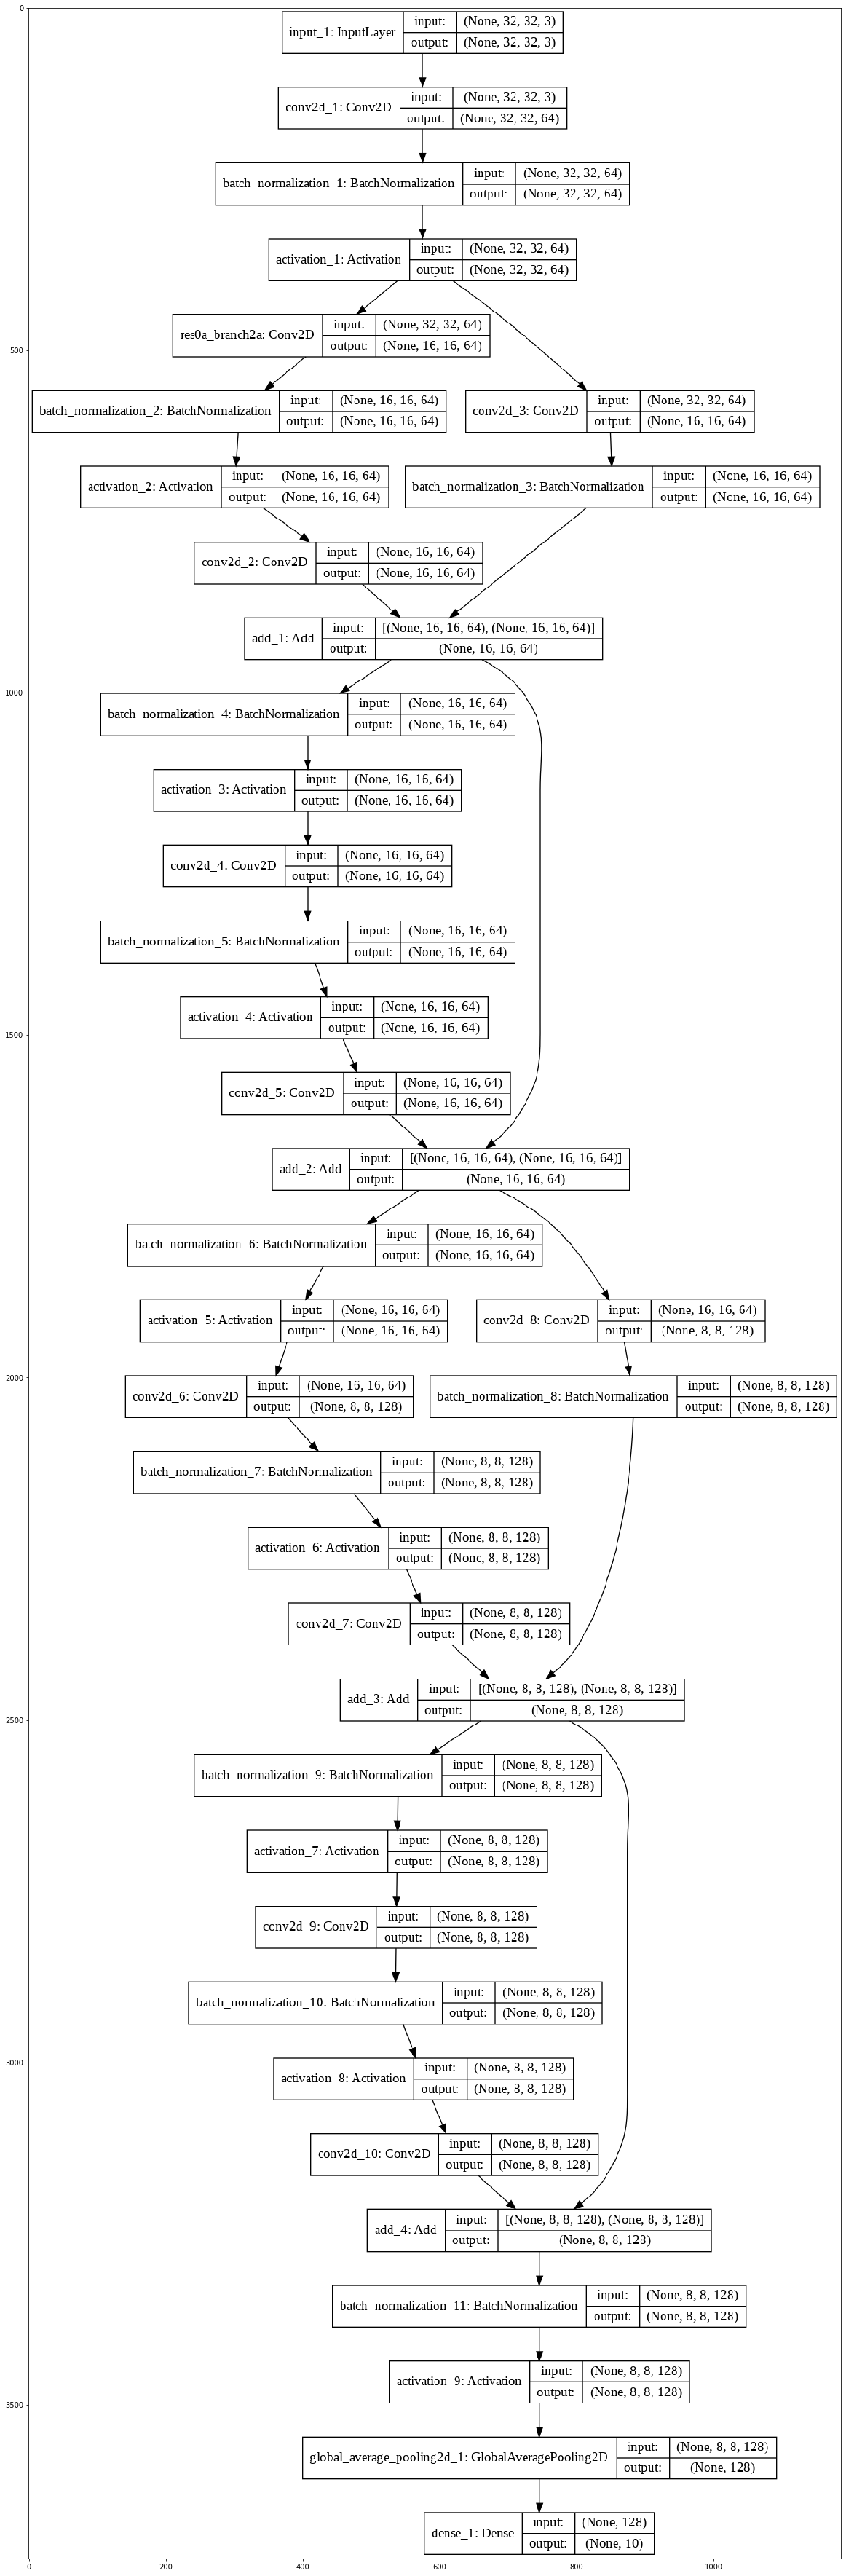

In [19]:
from keras.utils.vis_utils import plot_model


model = ResNet9((32,32,3),10)

from keras import optimizers
sgd = optimizers.SGD( lr=0.01, decay=1e-6, momentum=0.9,nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,#'adam',#'sgd',#'Adam(0.1)',
              metrics=['accuracy'])

plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/EVA/13/RESNET_9_plot.png', show_shapes=True, show_layer_names=True)


import matplotlib.pyplot as plt 
import cv2 
img = cv2.imread('/content/drive/My Drive/Colab Notebooks/EVA/13/RESNET_9_plot.png')
plt.figure(figsize=(20,90))
plt.imshow(img)


In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)



In [0]:
import matplotlib.pyplot as plt
import keras.backend as K
from keras.callbacks import Callback


class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()


In [0]:

lr_finder = LRFinder(min_lr=1e-5, 
                     max_lr=1e2, 
                     steps_per_epoch=np.ceil(50), 
                     epochs=3)

model = ResNet9((32,32,3),10)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,#'adam',#'sgd',#'Adam(0.1)',
              metrics=['accuracy'])

reshaping via a convolution...
reshaping via a convolution...


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3
  4/390 [..............................] - ETA: 10:03 - loss: 3.5085 - acc: 0.1367

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.159448). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


390/390 [==============================] - 56s 144ms/step - loss: 206.7775 - acc: 0.1017 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/3
390/390 [==============================] - 52s 132ms/step - loss: 14.5067 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/3
390/390 [==============================] - 51s 131ms/step - loss: 14.5074 - acc: 0.0999 - val_loss: 14.5063 - val_acc: 0.1000


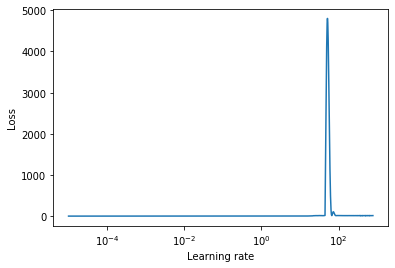

In [0]:

batch_size = 128
epochs = 3

model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(X_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=[lr_finder])

# model.fit_generator(tr_ch, epochs=4, steps_per_epoch=200, validation_steps=200,
#                     callbacks=[lr_finder],
#                     shuffle=True,
#                     validation_data=validation_generator_64)
            
lr_finder.plot_loss()

In [23]:

sgd = optimizers.SGD(lr=0.0004, decay=5e-4, momentum=0.9, nesterov=False)
# Define the model
model = ResNet9((32,32,3),10)


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

reshaping via a convolution...
reshaping via a convolution...


In [0]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='/content/drive/My Drive/Colab Notebooks/EVA/13/RESNET_18_plot.png', show_shapes=True, show_layer_names=True)


# import matplotlib.pyplot as plt 
# import cv2 
# img = cv2.imread('/content/drive/My Drive/Colab Notebooks/EVA/13/RESNET_18_plot.png')
# plt.figure(figsize=(20,90))
# plt.imshow(img)


##Training

In [24]:
from keras.callbacks import ModelCheckpoint
from keras import optimizers

model = ResNet9((32,32,3),10)
sgd = optimizers.SGD(lr=0.01, decay=5e-4, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

reshaping via a convolution...
reshaping via a convolution...


In [0]:
filepath="/content/drive/My Drive/Colab Notebooks/EVA/13/epochs:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
#file path store weights in google drive

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
batch_size = 128
epochs = 100

schedule = SGDRScheduler(min_lr=1e-3,
                         max_lr=1e-1,
                         steps_per_epoch=np.ceil(390),
                         lr_decay=0.9,
                         cycle_length=5,
                         mult_factor=1.5)


# checkpoint = ModelCheckpoint(filepath='../content/drive/My Drive/Colab Notebooks/EVA/13/Assingment_13.h5', 
#                              monitor='val_acc', mode='max', verbose = 1, save_best_only=True)

# model=keras.models.load_model('/content/drive/My Drive/Colab Notebooks/EVA/13/epochs:041-val_acc:0.791.hdf5')
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(X_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=[checkpoint,schedule])

Epoch 1/100
  4/390 [..............................] - ETA: 4:56 - loss: 2.5369 - acc: 0.1660

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.207831). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


390/390 [==============================] - 54s 137ms/step - loss: 1.6549 - acc: 0.4657 - val_loss: 2.1711 - val_acc: 0.4551

Epoch 00001: val_acc improved from -inf to 0.45510, saving model to /content/drive/My Drive/Colab Notebooks/EVA/13/epochs:001-val_acc:0.455.hdf5
Epoch 2/100
390/390 [==============================] - 51s 131ms/step - loss: 1.2128 - acc: 0.6412 - val_loss: 1.3438 - val_acc: 0.6140

Epoch 00002: val_acc improved from 0.45510 to 0.61400, saving model to /content/drive/My Drive/Colab Notebooks/EVA/13/epochs:002-val_acc:0.614.hdf5
Epoch 3/100
390/390 [==============================] - 50s 129ms/step - loss: 1.0066 - acc: 0.7132 - val_loss: 0.9725 - val_acc: 0.7299

Epoch 00003: val_acc improved from 0.61400 to 0.72990, saving model to /content/drive/My Drive/Colab Notebooks/EVA/13/epochs:003-val_acc:0.730.hdf5
Epoch 4/100
390/390 [==============================] - 50s 129ms/step - loss: 0.8742 - acc: 0.7627 - val_loss: 0.9460 - val_acc: 0.7416

Epoch 00004: val_acc im

In [0]:
model=keras.models.load_model('/content/drive/My Drive/Colab Notebooks/EVA/13/epochs:068-val_acc:0.892.hdf5')














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
schedule = SGDRScheduler(min_lr=1e-3,
                         max_lr=2e-1,
                         steps_per_epoch=np.ceil(390),
                         lr_decay=0.9,
                         cycle_length=5,
                         mult_factor=1.5)

In [0]:
batch_size = 128
epochs = 50
# checkpoint = ModelCheckpoint(filepath='../content/drive/My Drive/Colab Notebooks/EVA/13/Assingment_13.h5', 
#                              monitor='val_acc', mode='max', verbose = 1, save_best_only=True)
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(X_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=[checkpoint,schedule])

Epoch 1/50
390/390 [==============================] - 30s 77ms/step - loss: 0.4351 - acc: 0.8962 - val_loss: 0.9964 - val_acc: 0.7821

Epoch 00001: val_acc improved from -inf to 0.78210, saving model to /content/drive/My Drive/Colab Notebooks/EVA/13/epochs:001-val_acc:0.782.hdf5
Epoch 2/50
390/390 [==============================] - 26s 68ms/step - loss: 0.3899 - acc: 0.9138 - val_loss: 0.6764 - val_acc: 0.8374

Epoch 00002: val_acc improved from 0.78210 to 0.83740, saving model to /content/drive/My Drive/Colab Notebooks/EVA/13/epochs:002-val_acc:0.837.hdf5
Epoch 3/50
390/390 [==============================] - 26s 68ms/step - loss: 0.3410 - acc: 0.9306 - val_loss: 0.5818 - val_acc: 0.8713

Epoch 00003: val_acc improved from 0.83740 to 0.87130, saving model to /content/drive/My Drive/Colab Notebooks/EVA/13/epochs:003-val_acc:0.871.hdf5
Epoch 4/50
390/390 [==============================] - 26s 67ms/step - loss: 0.3003 - acc: 0.9461 - val_loss: 0.5313 - val_acc: 0.8817

Epoch 00004: val_ac

In [0]:
schedule = SGDRScheduler(min_lr=1e-4,
                         max_lr=1e-1,
                         steps_per_epoch=np.ceil(390),
                         lr_decay=0.9,
                         cycle_length=5,
                         mult_factor=1.5)

batch_size = 128
epochs = 50
model=keras.models.load_model('/content/drive/My Drive/Colab Notebooks/EVA/13/epochs:041-val_acc:0.897.hdf5')
# checkpoint = ModelCheckpoint(filepath='../content/drive/My Drive/Colab Notebooks/EVA/13/Assingment_13.h5', 
#                              monitor='val_acc', mode='max', verbose = 1, save_best_only=True)
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(X_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=[checkpoint,schedule])

Epoch 1/50
390/390 [==============================] - 27s 69ms/step - loss: 0.2250 - acc: 0.9671 - val_loss: 0.5780 - val_acc: 0.8828

Epoch 00001: val_acc did not improve from 0.89670
Epoch 2/50
390/390 [==============================] - 26s 67ms/step - loss: 0.2237 - acc: 0.9674 - val_loss: 0.5517 - val_acc: 0.8875

Epoch 00002: val_acc did not improve from 0.89670
Epoch 3/50
390/390 [==============================] - 26s 66ms/step - loss: 0.2124 - acc: 0.9726 - val_loss: 0.5436 - val_acc: 0.8884

Epoch 00003: val_acc did not improve from 0.89670
Epoch 4/50
390/390 [==============================] - 26s 66ms/step - loss: 0.2026 - acc: 0.9755 - val_loss: 0.5108 - val_acc: 0.8948

Epoch 00004: val_acc did not improve from 0.89670
Epoch 5/50
390/390 [==============================] - 26s 67ms/step - loss: 0.1975 - acc: 0.9780 - val_loss: 0.5101 - val_acc: 0.8944

Epoch 00005: val_acc did not improve from 0.89670
Epoch 6/50
390/390 [==============================] - 26s 67ms/step - loss:

In [26]:

schedule = SGDRScheduler(min_lr=1e-3,
                         max_lr=1e-1,
                         steps_per_epoch=np.ceil(390),
                         lr_decay=0.9,
                         cycle_length=5,
                         mult_factor=1.5)

model = ResNet9((32,32,3),10)
sgd = optimizers.SGD(lr=0.001, decay=5e-4, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)
batch_size =128
epochs = 50
model=keras.models.load_model('/content/drive/My Drive/Colab Notebooks/EVA/13/epochs:041-val_acc:0.899.hdf5')
# # checkpoint = ModelCheckpoint(filepath='../content/drive/My Drive/Colab Notebooks/EVA/13/Assingment_13.h5', 
# #                              monitor='val_acc', mode='max', verbose = 1, save_best_only=True)
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_data=(X_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=[checkpoint,schedule])

reshaping via a convolution...
reshaping via a convolution...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
390/390 [==============================] - 54s 138ms/step - loss: 0.1872 - acc: 0.9764 - val_loss: 0.6431 - val_acc: 0.8800

Epoch 00001: val_acc improved from -inf to 0.88000, saving model to /content/drive/My Drive/Colab Notebooks/EVA/13/epochs:001-val_acc:0.880.hdf5
Epoch 2/50
390/390 [==============================] - 49s 127ms/step - loss: 0.1895 - acc: 0.9764 - val_loss: 0.5698 - val_acc: 0.8903

Epoch 00002: val_acc improved from 0.88000 to 0.89030, saving model to /content/drive/My Drive/Colab Notebooks/EVA/13/epochs:002-val_acc:0.890.hdf5
Epoch 3/50
390/390 [==============================] - 50s 127ms/step - loss: 0.1801 - acc: 0.9803 - val_loss: 0.5368 - val_acc: 0.8961

Epoch 00003: val_acc improved from 0.89030 to 0.89610, saving model to /content/drive/My Drive/Colab Notebooks/EVA/13/epochs:003-val_acc:0.89

In [28]:
model=keras.models.load_model('/content/drive/My Drive/Colab Notebooks/EVA/13/epochs:023-val_acc:0.901.hdf5')
model.evaluate(X_test,y_test)

10000/10000 [==============================] - 5s 470us/step


[0.5255691174983979, 0.9007]

##Approach:
Augentation :

- Padding(8,8)
- random cropping(32,32)
- Flip(0.5)
- Cutout

Model:

- Resnet9

Learning Type:

- cyclic learning


Epochs:

- 250
